##importing libraries

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set(style="whitegrid")


##loading dataset

In [4]:
df = pd.read_csv('streamflow_filled.csv')
df.head()

,Date,Unnamed: 0,Year,Month,Day,Q (m3/s)
0,1967-01-01,11963,1967,1,1,2690.0
1,1967-01-02,11964,1967,1,2,2650.0
2,1967-01-03,11965,1967,1,3,2650.0
3,1967-01-04,11966,1967,1,4,2610.0
4,1967-01-05,11967,1967,1,5,2570.0


##exploring data

In [5]:
df.isnull().sum()

,0
Date,0
Unnamed: 0,0
Year,0
Month,0
Day,0
Q (m3/s),0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18628 entries, 0 to 18627
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        18628 non-null  object 
 1   Unnamed: 0  18628 non-null  int64  
 2   Year        18628 non-null  int64  
 3   Month       18628 non-null  int64  
 4   Day         18628 non-null  int64  
 5   Q (m3/s)    18628 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 873.3+ KB


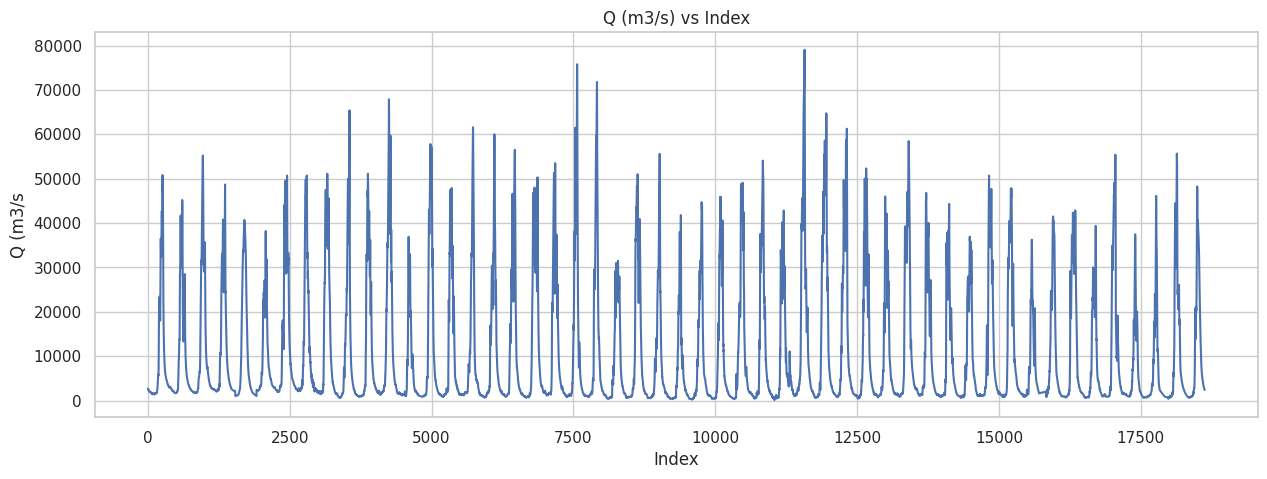

In [11]:
df.info()
plt.figure(figsize=(15,5))
plt.plot(df.index , df['Q (m3/s)'] )
plt.title('Q (m3/s) vs Index')
plt.xlabel('Index')
plt.ylabel('Q (m3/s')
plt.show()

Monthly dataset

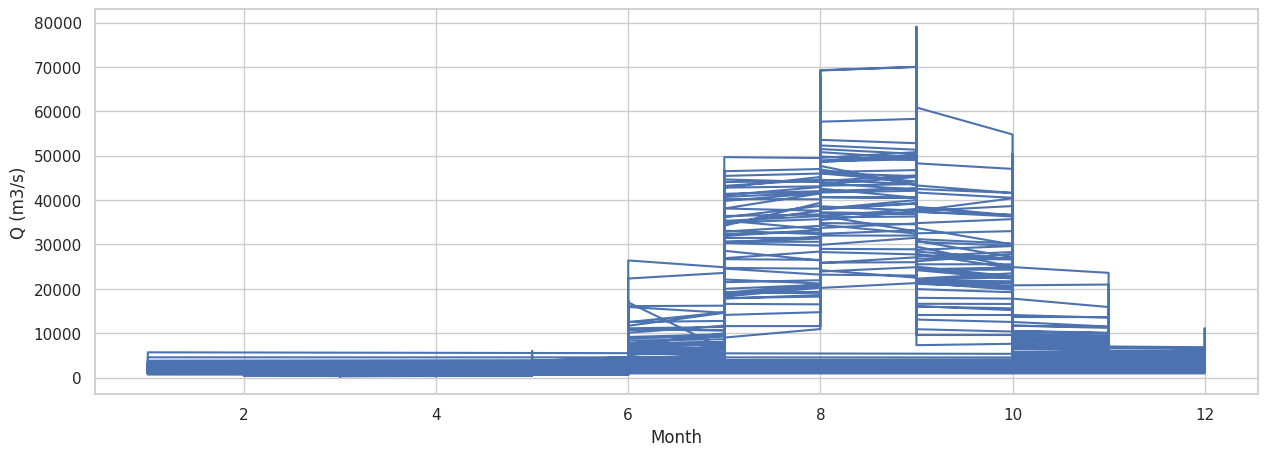

In [12]:
plt.figure(figsize=(15,5))
plt.plot(df.Month , df['Q (m3/s)'] )
plt.xlabel('Month')
plt.ylabel('Q (m3/s)')
plt.show()

In [23]:
df['Date'] = pd.to_datetime(df['Date'])

df = df.set_index('Date')

df = df.sort_index()

monthly = df.resample('ME').mean()
monthly.head()


,Unnamed: 0,Year,Month,Day,Q (m3/s)
Date,,,,,
1967-01-31,11978.0,1967.0,1.0,16.0,2309.354839
1967-02-28,12007.5,1967.0,2.0,14.5,1950.714286
1967-03-31,12037.0,1967.0,3.0,16.0,1550.967742
1967-04-30,12067.5,1967.0,4.0,15.5,1527.666667
1967-05-31,12098.0,1967.0,5.0,16.0,1615.161290


<Figure size 1500x500 with 0 Axes>

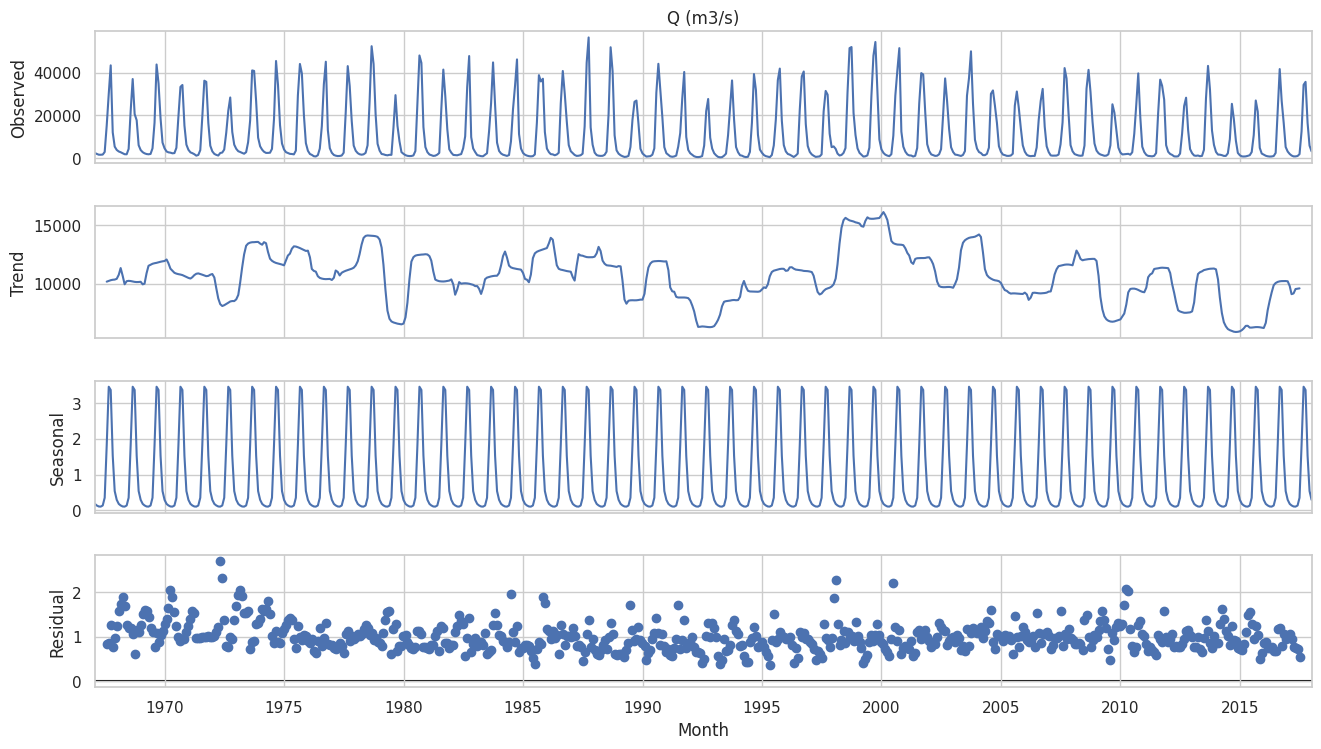

In [29]:
plt.figure(figsize=(15,5))
seasons = seasonal_decompose(monthly['Q (m3/s)'], model='multiplicative' , period = 12)
fig = seasons.plot()
fig.set_size_inches(15, 8)
fig.axes[0].set_ylabel("Observed")
fig.axes[1].set_ylabel("Trend")
fig.axes[2].set_ylabel("Seasonal")
fig.axes[3].set_ylabel("Residual")
fig.axes[3].set_xlabel("Month")

plt.show()

Select target variable (Q m³/s)

In [30]:
target_col = 'Q (m3/s)'
series = df[target_col].astype(float)

Plot the time series

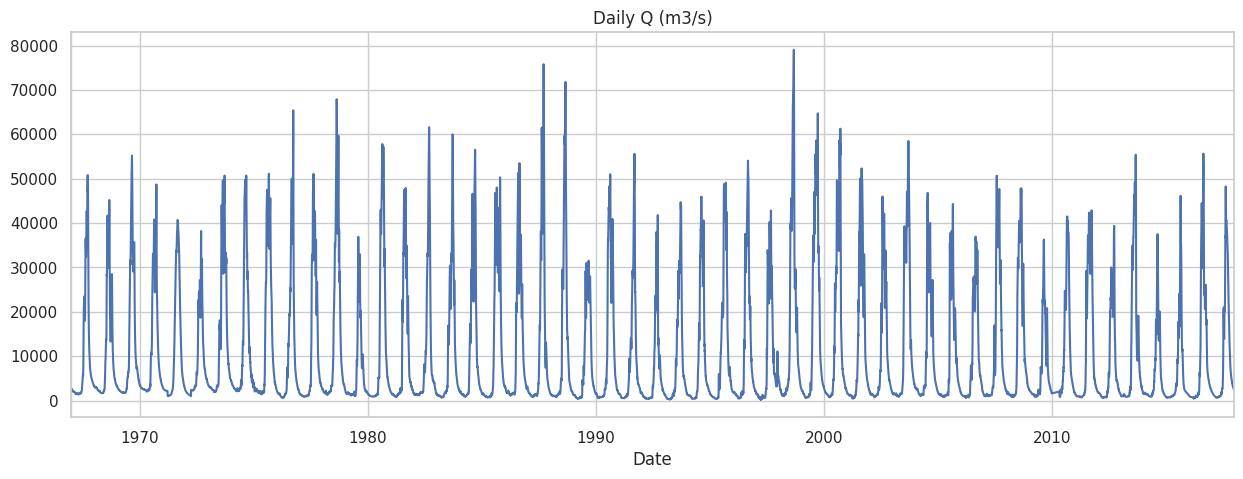

In [31]:
series.plot(figsize=(15,5), title = 'Daily Q (m3/s)')
plt.show()

###LSTMs work better with scaled values.

In [32]:
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series.values.reshape(-1,1))


###Creating input series

In [33]:
SEQ_LEN  = 30
def create_sequences(data , seq_len):
  X,y = [] ,[]
  for i in range(len(data) - seq_len):
    X.append(data[i:i+seq_len])
    y.append(data[i+seq_len])
  return np.array(X) , np.array(y)
X,y = create_sequences(series_scaled , SEQ_LEN)
X.shape , y.shape



((18598, 30, 1), (18598, 1))

###Splitting the data

In [34]:
split = int(0.85 *len(X))
X_train , y_train = X[:split] , y[:split]
X_test , y_test = X[split:] , y[split:]


##model

In [35]:
tf.random.set_seed(42)
model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, 1), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

###Train

In [36]:
es = EarlyStopping(monitor="val_loss",
                                    patience=5,
                                    restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[es]
)

Epoch 1/200
494/494 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0035 - mae: 0.0295 - val_loss: 2.6570e-04 - val_mae: 0.0092
Epoch 2/200
494/494 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 4.8384e-04 - mae: 0.0124 - val_loss: 1.6055e-04 - val_mae: 0.0073
Epoch 3/200
494/494 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 3.2473e-04 - mae: 0.0108 - val_loss: 1.2169e-04 - val_mae: 0.0082
Epoch 4/200
494/494 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 2.6325e-04 - mae: 0.0099 - val_loss: 1.0265e-04 - val_mae: 0.0068
Epoch 5/200
494/494 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 2.3717e-04 - mae: 0.0096 - val_loss: 8.9930e-05 - val_mae: 0.0051
Epoch 6/200
494/494 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 2.0406e-04 - mae: 0.0091 - val_loss: 1.0625e-04 - val_mae: 0.0062
Epoch 7/200
494/494 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 2.0344e-04 - mae: 0.0090 - val_loss: 6.1822e-05 - val_mae: 0.0041
Epoch 8/200
494/494 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 1.8228e-04 - mae: 0.0086 - val_loss: 1.4440

###Evaluating the model

In [38]:
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)
y_test_inv = scaler.inverse_transform(y_test)
mae = mean_absolute_error(y_test_inv, pred)
mse = mean_squared_error(y_test_inv, pred)
rmse = math.sqrt(mse)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
MAE: 320.6752788042274
MSE: 274497.8830787551
RMSE: 523.9254556506633


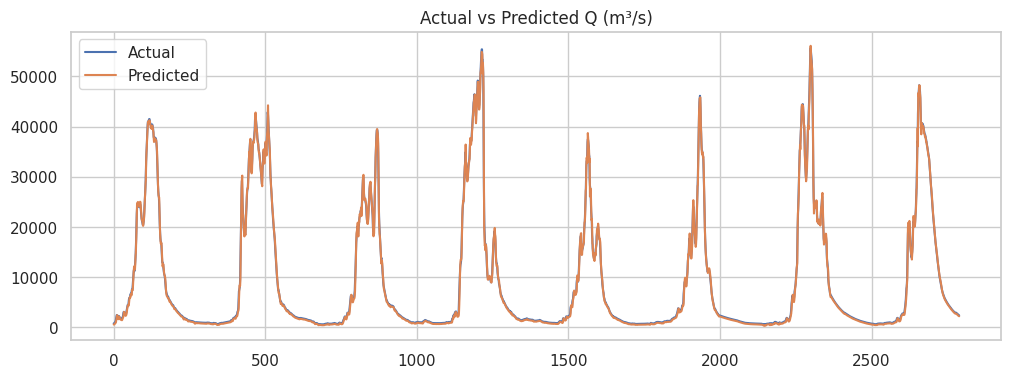

In [39]:
plt.figure(figsize=(12,4))
plt.plot(y_test_inv, label='Actual')
plt.plot(pred, label='Predicted')
plt.legend()
plt.title("Actual vs Predicted Q (m³/s)")
plt.show()


###Forecast future values

In [41]:
def forecast_future(model, last_sequence, n):
    seq = last_sequence.copy()
    preds = []
    for _ in range(n):
        p = model.predict(seq.reshape(1, SEQ_LEN, 1))[0]
        preds.append(p)
        seq = np.vstack([seq[1:], p])
    return np.array(preds)

last_seq = series_scaled[-SEQ_LEN:]
future_scaled = forecast_future(model, last_seq, 7)
future = scaler.inverse_transform(future_scaled)
future


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


array([[2177.9045 ],
       [2016.5007 ],
       [1793.6222 ],
       [1560.5302 ],
       [1310.3516 ],
       [1049.9113 ],
       [ 781.67926]], dtype=float32)

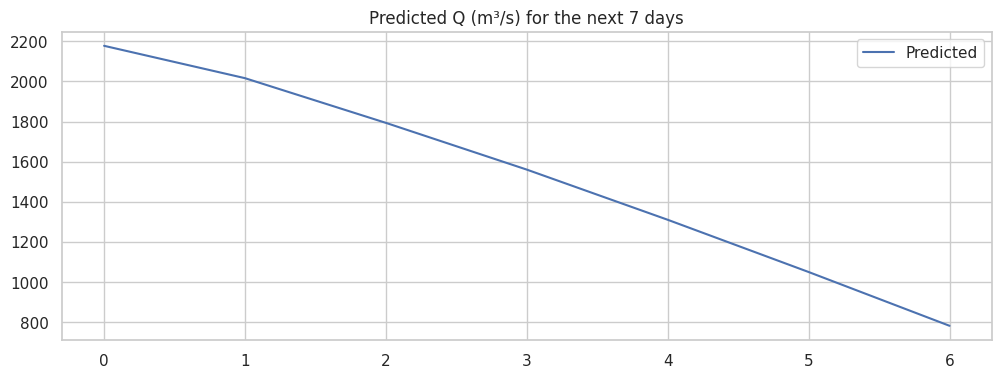

In [42]:
plt.figure(figsize=(12,4))
plt.plot(future, label='Predicted')
plt.legend()
plt.title("Predicted Q (m³/s) for the next 7 days")
plt.show()

###Plot of the last 30 real values + next 7 predicted values

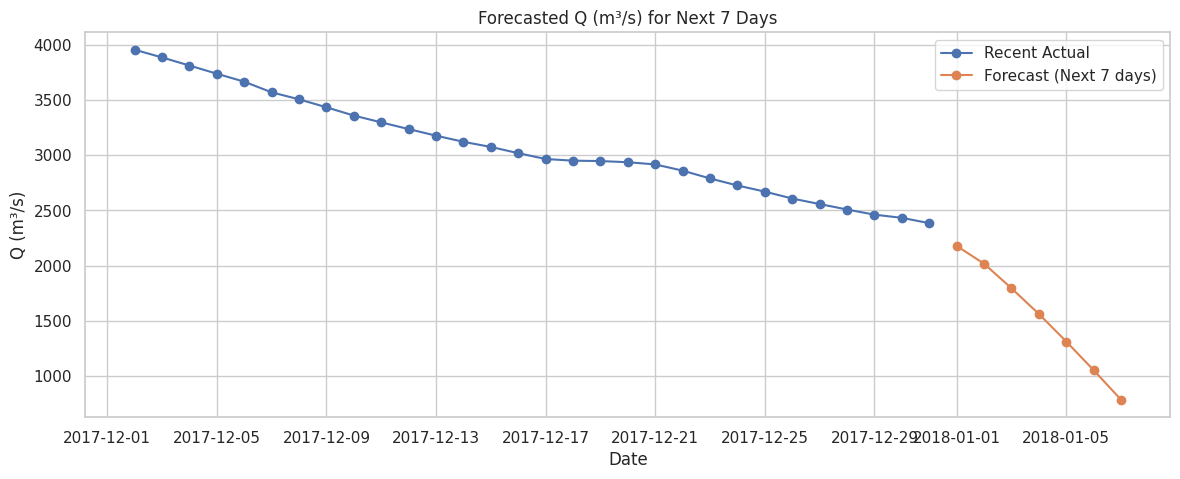

In [44]:

history_days = 30
recent_actual = series[-history_days:]
last_date = series.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7)

future_series = pd.Series(future.flatten(), index=future_dates)

plt.figure(figsize=(14,5))
plt.plot(recent_actual.index, recent_actual.values, label="Recent Actual", marker='o')
plt.plot(future_series.index, future_series.values, label="Forecast (Next 7 days)", marker='o')

plt.title("Forecasted Q (m³/s) for Next 7 Days")
plt.xlabel("Date")
plt.ylabel("Q (m³/s)")
plt.legend()
plt.grid(True)
plt.show()


###single continuous plot (acutal one  + predicted)

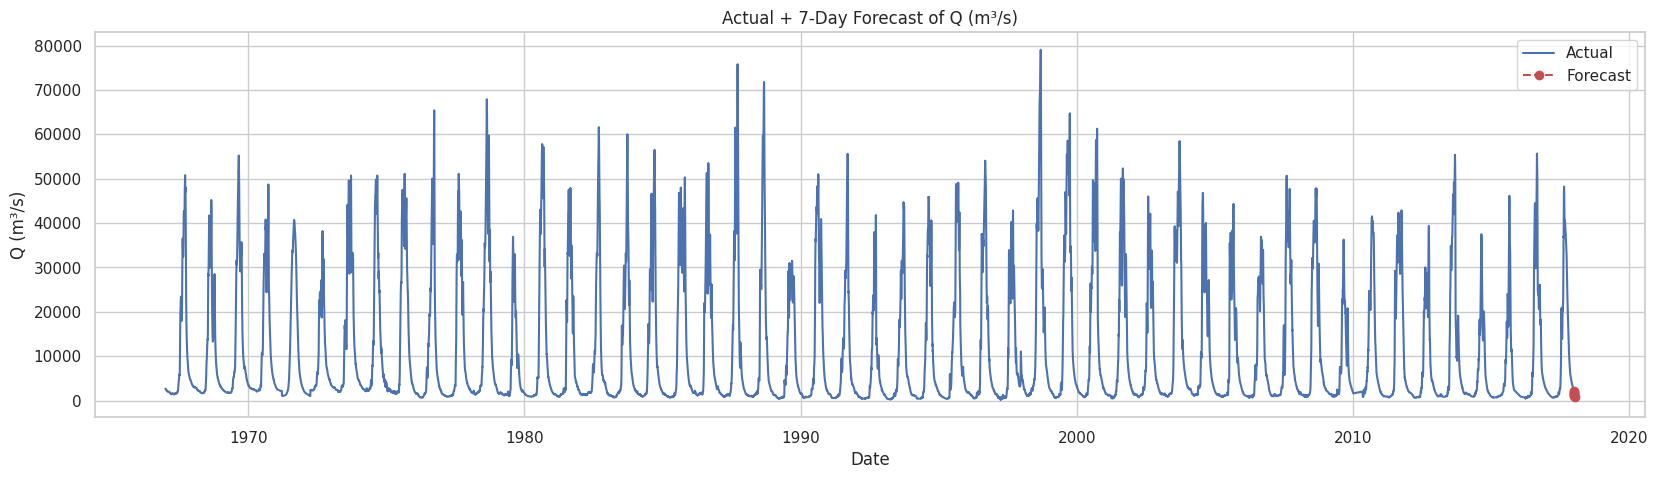

In [46]:
plt.figure(figsize=(20,5))
plt.plot(series.index, series.values, label="Actual")
plt.plot(future_dates, future.flatten(), 'r--o', label="Forecast")
plt.title("Actual + 7-Day Forecast of Q (m³/s)")
plt.xlabel("Date")
plt.ylabel("Q (m³/s)")
plt.legend()
plt.grid(True)
plt.show()
